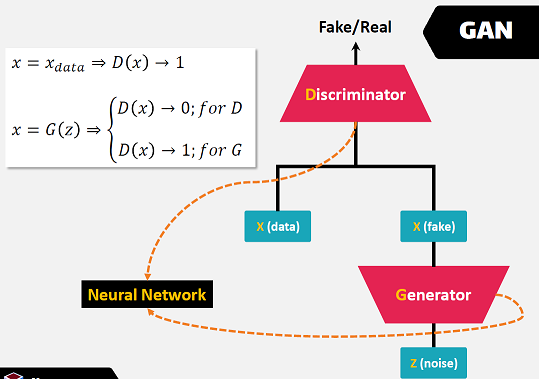

In [1]:
lr = 3e-4
input_genrator = 10 # less than input features or output generator
input_features = 41 # or output generator
batch_size = 4000
num_epochs = 50

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data.dataset import Dataset
from torch.utils.data import random_split, DataLoader
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.autograd import Variable 

device = "cuda" if torch.cuda.is_available() else "cpu"

def plot_history(d_hist, g_hist):
    plt.plot(d_hist, label='Discriminator')
    plt.plot(g_hist, label='Generator')
    plt.legend(['Discriminator','Generator'])
    plt.show()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


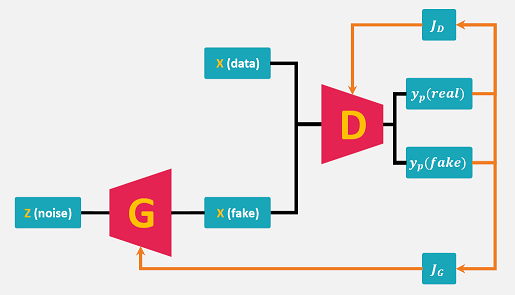

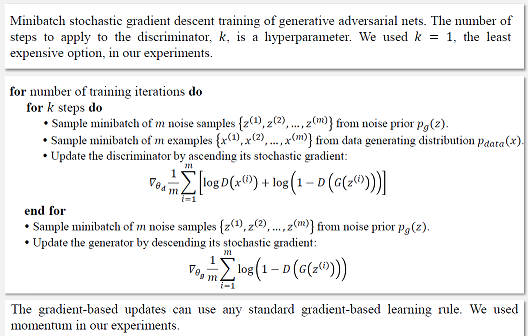

In [4]:
class DataSet_UNSWNB15_attack_cat(Dataset):

    def __init__(self,data_set_path):
        df = pd.read_csv(data_set_path)
        # print(df.attack_cat.value_counts().sort_values().plot(kind = "barh"))
        
        # preprocceing
        df.drop(['id',"Unnamed: 0","service","label"], axis=1, inplace=True)        
        cols = ['attack_cat' ,'proto' ,'state']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
      
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

        
class DataSet_UNSWNB15_label(Dataset):

    def __init__(self,data_set_path):
        df = pd.read_csv(data_set_path)
        # print(df.label.value_counts().sort_values().plot(kind = "pie"))

        # preprocceing
        df.drop(['id',"Unnamed: 0","service","attack_cat"], axis=1, inplace=True)
        cols = ['proto' ,'state']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
        
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

# **create Generator and Discriminator**

In [5]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, input_genrator, in_features):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(input_genrator, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, in_features),
            # nn.Tanh()  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

# **attack category**

Epoch [0/50] loss D: 0.7483, loss G: 0.7805
Epoch [1/50] loss D: 0.5760, loss G: 0.9048
Epoch [2/50] loss D: 0.6178, loss G: 0.6915
Epoch [3/50] loss D: 0.5093, loss G: 0.9640
Epoch [4/50] loss D: 0.4998, loss G: 0.9212
Epoch [5/50] loss D: 0.5611, loss G: 0.8017
Epoch [6/50] loss D: 0.8060, loss G: 0.7496
Epoch [7/50] loss D: 0.7225, loss G: 0.9115
Epoch [8/50] loss D: 0.6604, loss G: 0.9956
Epoch [9/50] loss D: 0.6670, loss G: 0.9216
Epoch [10/50] loss D: 0.6529, loss G: 0.9342
Epoch [11/50] loss D: 0.6202, loss G: 0.8698
Epoch [12/50] loss D: 0.6527, loss G: 0.7425
Epoch [13/50] loss D: 0.7208, loss G: 0.6822
Epoch [14/50] loss D: 0.6903, loss G: 0.8867
Epoch [15/50] loss D: 0.6557, loss G: 0.9211
Epoch [16/50] loss D: 0.6693, loss G: 0.7510
Epoch [17/50] loss D: 0.6190, loss G: 0.8419
Epoch [18/50] loss D: 0.6483, loss G: 0.7589
Epoch [19/50] loss D: 0.6777, loss G: 0.7744
Epoch [20/50] loss D: 0.7195, loss G: 0.7447
Epoch [21/50] loss D: 0.6680, loss G: 0.8488
Epoch [22/50] loss D

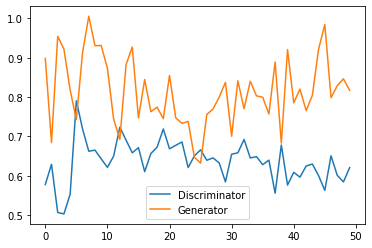

In [6]:
disc = Discriminator(input_features).to(device)
gen = Generator(input_genrator, input_features).to(device)

dataset = DataSet_UNSWNB15_attack_cat("/content/drive/MyDrive/datasets/UNSW-NB15/UNSW_NB15.csv")
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = opt.Adam(disc.parameters(), lr=lr)
opt_gen = opt.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()

d_history = []
g_history = []

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, input_genrator).to(device)
        fake = gen(noise)
        # print(real.shape)
        disc_real = disc(real)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = disc(fake)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            # print(real,fake)
            print(f"Epoch [{epoch}/{num_epochs}] loss D: {lossD:.4f}, loss G: {lossG:.4f}")
    d_history.append(lossD.cpu().detach().numpy().item())
    g_history.append(lossG.cpu().detach().numpy().item())
            # print(d_history)
plot_history(d_history, g_history)

# **label**

Epoch [0/50] loss D: 0.6800, loss G: 0.7231
Epoch [1/50] loss D: 0.5171, loss G: 0.8343
Epoch [2/50] loss D: 0.5621, loss G: 1.3914
Epoch [3/50] loss D: 0.5555, loss G: 1.1539
Epoch [4/50] loss D: 0.4962, loss G: 0.9991
Epoch [5/50] loss D: 0.7282, loss G: 0.7242
Epoch [6/50] loss D: 0.6454, loss G: 0.9690
Epoch [7/50] loss D: 0.6638, loss G: 0.8718
Epoch [8/50] loss D: 0.6730, loss G: 0.7209
Epoch [9/50] loss D: 0.7255, loss G: 0.7658
Epoch [10/50] loss D: 0.6863, loss G: 0.8312
Epoch [11/50] loss D: 0.6718, loss G: 0.7649
Epoch [12/50] loss D: 0.6227, loss G: 0.7341
Epoch [13/50] loss D: 0.6432, loss G: 0.7467
Epoch [14/50] loss D: 0.5626, loss G: 0.9022
Epoch [15/50] loss D: 0.5977, loss G: 0.8938
Epoch [16/50] loss D: 0.6191, loss G: 0.9086
Epoch [17/50] loss D: 0.6331, loss G: 0.7573
Epoch [18/50] loss D: 0.6389, loss G: 0.9058
Epoch [19/50] loss D: 0.5680, loss G: 0.8810
Epoch [20/50] loss D: 0.5897, loss G: 0.8805
Epoch [21/50] loss D: 0.5468, loss G: 0.9584
Epoch [22/50] loss D

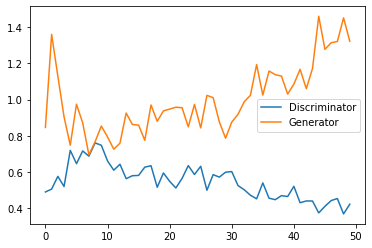

In [7]:
disc = Discriminator(input_features).to(device)
gen = Generator(input_genrator, input_features).to(device)

dataset = DataSet_UNSWNB15_label("/content/drive/MyDrive/datasets/UNSW-NB15/UNSW_NB15.csv")
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = opt.Adam(disc.parameters(), lr=lr)
opt_gen = opt.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()

d_history = []
g_history = []

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, input_genrator).to(device)
        fake = gen(noise)
        # print(real.shape)
        disc_real = disc(real)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = disc(fake)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            # print(real,fake)
            print(f"Epoch [{epoch}/{num_epochs}] loss D: {lossD:.4f}, loss G: {lossG:.4f}")
    d_history.append(lossD.cpu().detach().numpy().item())
    g_history.append(lossG.cpu().detach().numpy().item())
            # print(d_history)
plot_history(d_history, g_history)